In [ ]:
# Transfer Learning with MobileNet

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
# You will need to load the images.
# Download the Chessman image dataset by Nitesh Yadav from Kaggle: 
# https://www.kaggle.com/niteshfre/chessman-image-dataset
# Either get the file from Kaggle API, manually upload the archive.zip file,
# Or mount Google Drive.

In [ ]:
#!unzip archive.zip

In [ ]:
labelDictionary = {'Pawn': 0, 'Knight': 1, 'Bishop': 2, 'Rook': 3, 'Queen': 4, 'King': 5}
class_names = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen', 'King']

In [ ]:
# Change basepath, depending on how you uploaded your data.
basepath = "Chessman-image-dataset/Chess"

images=[]
labels=[]

# Loop through each folder in the directory
for folder in os.listdir(basepath):
  label = folder
  # Loop through each file in the directory
  for file in os.listdir(basepath+ "/" + folder):
    if 'jpg' in file:
      new_img = cv2.resize(cv2.imread(basepath+ "//" + folder + "//" + file), (224,224))
      images.append(new_img)
      labels.append(labelDictionary[label])

images = np.array(images)
labels = np.array(labels)

In [ ]:
# Shuffle our data
(images, labels) = shuffle(images, labels)

In [ ]:
# Split our dataset: 60% training, 20% validation, and 20% testing.
x_train, x_remainder, y_train, y_remainder = train_test_split(images, labels, train_size=0.6)
x_valid, x_test, y_valid, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(279, 224, 224, 3)
(279,)
(93, 224, 224, 3)
(93,)
(93, 224, 224, 3)
(93,)


In [ ]:
# Use random data augmentation to artificially introduce sample diversity
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = train_datagen.flow(x_valid, y_valid, batch_size=8, seed=1) 

In [ ]:
# Instantiate the MobileNet model
base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, 
                             input_shape=(224, 224, 3))
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
# Freeze layers and add new trainable layers
base_model.trainable = False

# Inference mode, so batchnorm layers will not update their batch statistics
out = base_model(base_model.input, training=False)
out = GlobalAveragePooling2D()(out)
out = Dropout(0.3)(out)
out = Dense(500, activation="relu")(out)
out = Dropout(0.3)(out)
out = Dense(500, activation="relu")(out)
out = Dropout(0.3)(out)
outputs = Dense(6, activation='softmax')(out)
model = keras.Model(base_model.input, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0     

In [ ]:
# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

f_model = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // 32,
                    validation_data=valid_generator,
                    epochs=35, verbose=1)

Epoch 1/35
8/8 [==============================] - 6s 456ms/step - loss: 2.0864 - accuracy: 0.2591 - val_loss: 1.5172 - val_accuracy: 0.4086
Epoch 2/35
8/8 [==============================] - 3s 422ms/step - loss: 1.7087 - accuracy: 0.3239 - val_loss: 1.3122 - val_accuracy: 0.5161
Epoch 3/35
8/8 [==============================] - 3s 419ms/step - loss: 1.4088 - accuracy: 0.4534 - val_loss: 1.0929 - val_accuracy: 0.6237
Epoch 4/35
8/8 [==============================] - 3s 405ms/step - loss: 1.0766 - accuracy: 0.5628 - val_loss: 0.9261 - val_accuracy: 0.6882
Epoch 5/35
8/8 [==============================] - 3s 413ms/step - loss: 0.9859 - accuracy: 0.6154 - val_loss: 0.7620 - val_accuracy: 0.7419
Epoch 6/35
8/8 [==============================] - 3s 407ms/step - loss: 0.8766 - accuracy: 0.6397 - val_loss: 0.7303 - val_accuracy: 0.7312
Epoch 7/35
8/8 [==============================] - 3s 411ms/step - loss: 0.8452 - accuracy: 0.6640 - val_loss: 0.7521 - val_accuracy: 0.7419
Epoch 8/35
8/8 [====

In [ ]:
# Scale the testing set
x_test_scaled = x_test/255.

In [ ]:
# Find the total loss and accuracy of the testing set before unfreezing
score = model.evaluate(x_test_scaled, y_test)
print("Total loss on Testing Set: ", score[0])
print("Accuracy of Testing Set: ", score[1])
result = model.predict(x_test_scaled)

3/3 [==============================] - 1s 73ms/step - loss: 0.8140 - accuracy: 0.8065
Total loss on Testing Set:  0.8139929175376892
Accuracy of Testing Set:  0.8064516186714172


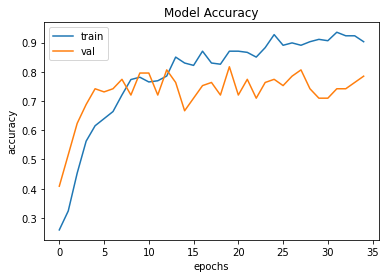

In [ ]:
# Plot Model Accuracy before unfreezing
plt.plot(f_model.history['accuracy'], label='train')
plt.plot(f_model.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

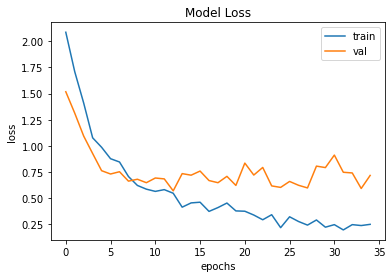

In [ ]:
# Plot Model Loss before unfreezing
plt.plot(f_model.history['loss'], label = 'train')
plt.plot(f_model.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
# Unfreeze the base model
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0     

In [ ]:
# Recompile model with low learning rate
model.compile(Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

uf_model = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // 32,
                    validation_data=valid_generator,
                    epochs=15, verbose=1)

Epoch 1/15
8/8 [==============================] - 6s 458ms/step - loss: 0.1945 - accuracy: 0.9231 - val_loss: 0.7828 - val_accuracy: 0.7634
Epoch 2/15
8/8 [==============================] - 3s 425ms/step - loss: 0.1799 - accuracy: 0.9352 - val_loss: 0.5611 - val_accuracy: 0.8065
Epoch 3/15
8/8 [==============================] - 3s 409ms/step - loss: 0.1089 - accuracy: 0.9717 - val_loss: 0.6011 - val_accuracy: 0.7527
Epoch 4/15
8/8 [==============================] - 3s 418ms/step - loss: 0.1505 - accuracy: 0.9514 - val_loss: 0.8057 - val_accuracy: 0.7204
Epoch 5/15
8/8 [==============================] - 3s 414ms/step - loss: 0.1222 - accuracy: 0.9636 - val_loss: 0.5936 - val_accuracy: 0.7849
Epoch 6/15
8/8 [==============================] - 3s 411ms/step - loss: 0.1055 - accuracy: 0.9676 - val_loss: 0.5330 - val_accuracy: 0.7957
Epoch 7/15
8/8 [==============================] - 3s 421ms/step - loss: 0.0963 - accuracy: 0.9766 - val_loss: 0.5687 - val_accuracy: 0.7742
Epoch 8/15
8/8 [====

In [ ]:
# Find the total loss and accuracy of the testing set after unfreezing
score = model.evaluate(x_test_scaled, y_test)
print("Total loss on Testing Set: ", score[0])
print("Accuracy of Testing Set: ", score[1])
result = model.predict(x_test_scaled)

3/3 [==============================] - 1s 27ms/step - loss: 0.6534 - accuracy: 0.8387
Total loss on Testing Set:  0.6534393429756165
Accuracy of Testing Set:  0.8387096524238586


In [ ]:
num = len(uf_model.history['accuracy'])
num_two = len(uf_model.history['val_accuracy'])

# Append accuracy data from new model to the old model
for i in range(num):
  f_model.history['accuracy'].append(uf_model.history['accuracy'][i])

for i in range(num_two):
  f_model.history['val_accuracy'].append(uf_model.history['val_accuracy'][i])

In [ ]:
num = len(uf_model.history['loss'])
num_two = len(uf_model.history['val_loss'])

# Append loss data from new model to the old model
for i in range(num):
  f_model.history['loss'].append(uf_model.history['loss'][i])

for i in range(num_two):
  f_model.history['val_loss'].append(uf_model.history['val_loss'][i])

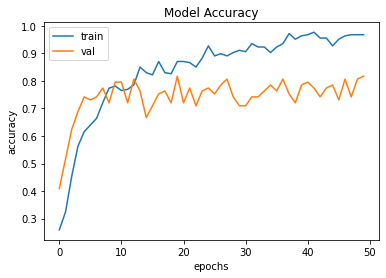

In [ ]:
# Plot Model Accuracy after unfreezing
plt.plot(f_model.history['accuracy'], label='train')
plt.plot(f_model.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

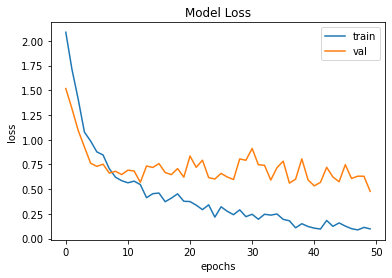

In [ ]:
# Plot Model Loss after unfreezing
plt.plot(f_model.history['loss'], label = 'train')
plt.plot(f_model.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
# Get the indices. Then, print out weighted precision, recall, and F1 scores
formatted_results = []
for i in range(len(result)):
  formatted_results.append(np.argmax(result[i]))

print("Weighted Precision Score: " + str(precision_score(y_test, formatted_results, average='weighted')))
print("Weighted Recall Score: " + str(recall_score(y_test, formatted_results, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(y_test, formatted_results, average='weighted')))

Weighted Precision Score: 0.8455260013833867
Weighted Recall Score: 0.8387096774193549
Weighted F1 Score: 0.8367701325988312


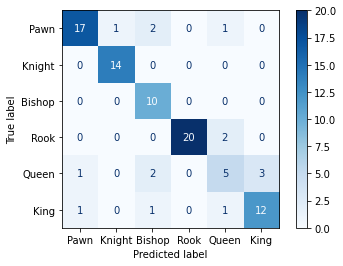

In [ ]:
# Plot and display confusion matrix
cm = confusion_matrix(y_test, formatted_results)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmDisplay.plot(cmap='Blues')
plt.show()

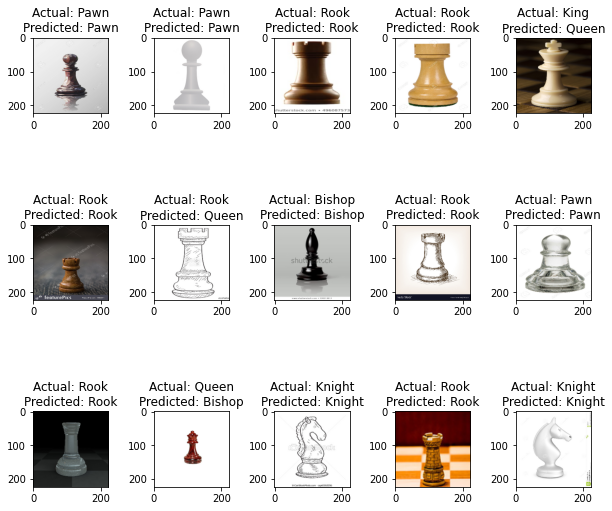

In [ ]:
# Display actual and predicted data of a few data from testing set
n_rows = 3
n_cols = 5
index = 0;
plt.figure(figsize=(10, 10))
for row in range(n_rows):
    for col in range(n_cols):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))
        plt.title("Actual: " + str(class_names[y_test[index]]) + "\nPredicted: " + str(class_names[np.argmax(result[index])]), fontsize=12)
        index += 1
plt.subplots_adjust(wspace=0.6, hspace=0.1)
plt.show()